In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import pandas as Pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image
import os

**•	TensorFlow and Keras:** Core tools for building and training your image classification model.
**•	EfficientNetV2B0:** A pre-built, powerful model that's already good at recognizing images. Using it saves a lot of time and effort compared to building a model from scratch.
**•	NumPy and Pandas:** For handling and organizing your data (like image information and labels) before and after you work with the AI model.
**•	Matplotlib and Seaborn:** Help you visualize your data and the results of your model performance.
**•	Scikit-learn metrics:** These give you ways to measure how good your model is at classifying images.
**•	Gradio: **This helps you create a simple web interface to test out your trained model with your own images.
**•	PIL (Pillow): **This is for opening and working with the image files themselves.
**•	OS:** This helps you navigate and interact with the folders and files on your computer.

In [28]:
import kagglehub

# Dataset path
path = kagglehub.dataset_download("akshat103/e-waste-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/e-waste-image-dataset


In [29]:
# Dataset path from kagglehub download
# dataset_base_path = "/kaggle/input/e-waste-image-dataset" # Original incorrect path
dataset_base_path = "/root/.cache/kagglehub/datasets/akshat103/e-waste-image-dataset/versions/1" # Corrected path based on kagglehub download output

#Training datset path
train_folder = os.path.join(dataset_base_path, "modified-dataset", "train")
#Testing datset path
test_folder = os.path.join(dataset_base_path, "modified-dataset", "test")
#Validation dataset path
val_folder = os.path.join(dataset_base_path, "modified-dataset", "val")

In [30]:
data_train= tf.keras.utils.image_dataset_from_directory(train_folder,shuffle=True,image_size=(150,150),batch_size=32,validation_split=False)
data_test= tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=False,image_size=(150,150),batch_size=32,validation_split=False)
data_val= tf.keras.utils.image_dataset_from_directory(val_folder,shuffle=True,image_size=(150,150),batch_size=32,validation_split=False)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [31]:
def get_counts(folder):
  counts={}
  for class_folder in os.listdir(folder) :
    class_path = os.path.join(folder,class_folder)
    if os.path.isdir(class_path):
      counts[class_folder] = len(os.listdir(class_path))
  return counts
train_counts = get_counts(train_folder)
test_counts = get_counts(test_folder)
val_counts = get_counts(val_folder)
print(len(data_train.class_names))
print("Training data")
print(train_counts)
print("Testing data")
print(test_counts)
print("Validation data")
print(val_counts)
#This block contains the counts of the individual datasets(files) that is trained,test and split

10
Training data
{'Mobile': 240, 'Player': 240, 'Television': 240, 'Keyboard': 240, 'Microwave': 240, 'PCB': 240, 'Washing Machine': 240, 'Printer': 240, 'Mouse': 240, 'Battery': 240}
Testing data
{'Mobile': 30, 'Player': 30, 'Television': 30, 'Keyboard': 30, 'Microwave': 30, 'PCB': 30, 'Washing Machine': 30, 'Printer': 30, 'Mouse': 30, 'Battery': 30}
Validation data
{'Mobile': 30, 'Player': 30, 'Television': 30, 'Keyboard': 30, 'Microwave': 30, 'PCB': 30, 'Washing Machine': 30, 'Printer': 30, 'Mouse': 30, 'Battery': 30}


In [32]:
df_train = Pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_test = Pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])
df_val = Pd.DataFrame(list(val_counts.items()), columns=['Class', 'Count'])
# The count of the datasets are converted to dataframes

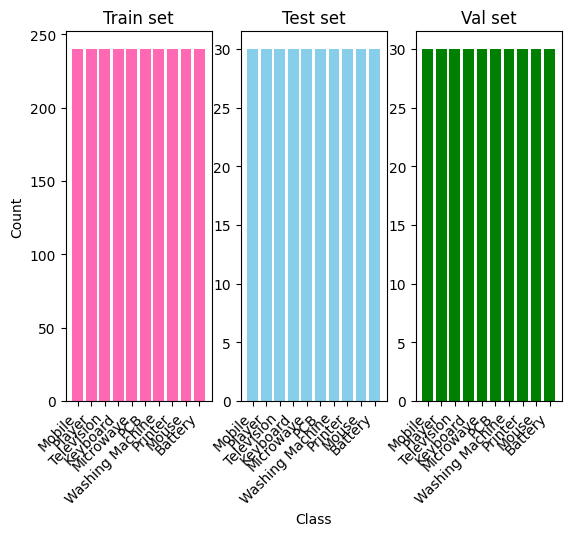

<Figure size 5000x3900 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

#plot count for tain data
plt.subplot(1,3,1)
plt.bar(df_train['Class'], df_train['Count'], color = 'hotpink')
plt.title('Train set')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

#plot count for test data
plt.subplot(1,3,2)
plt.bar(df_test['Class'], df_test['Count'], color = 'skyblue')
plt.title('Test set')
plt.xlabel('Class')
plt.xticks(rotation=45, ha='right')

#plot count for val data
plt.subplot(1,3,3)
plt.bar(df_val['Class'], df_val['Count'], color = 'green')
plt.title('Val set')
plt.xticks(rotation=45, ha='right')

plt.figure(figsize=(50,39))
plt.show()

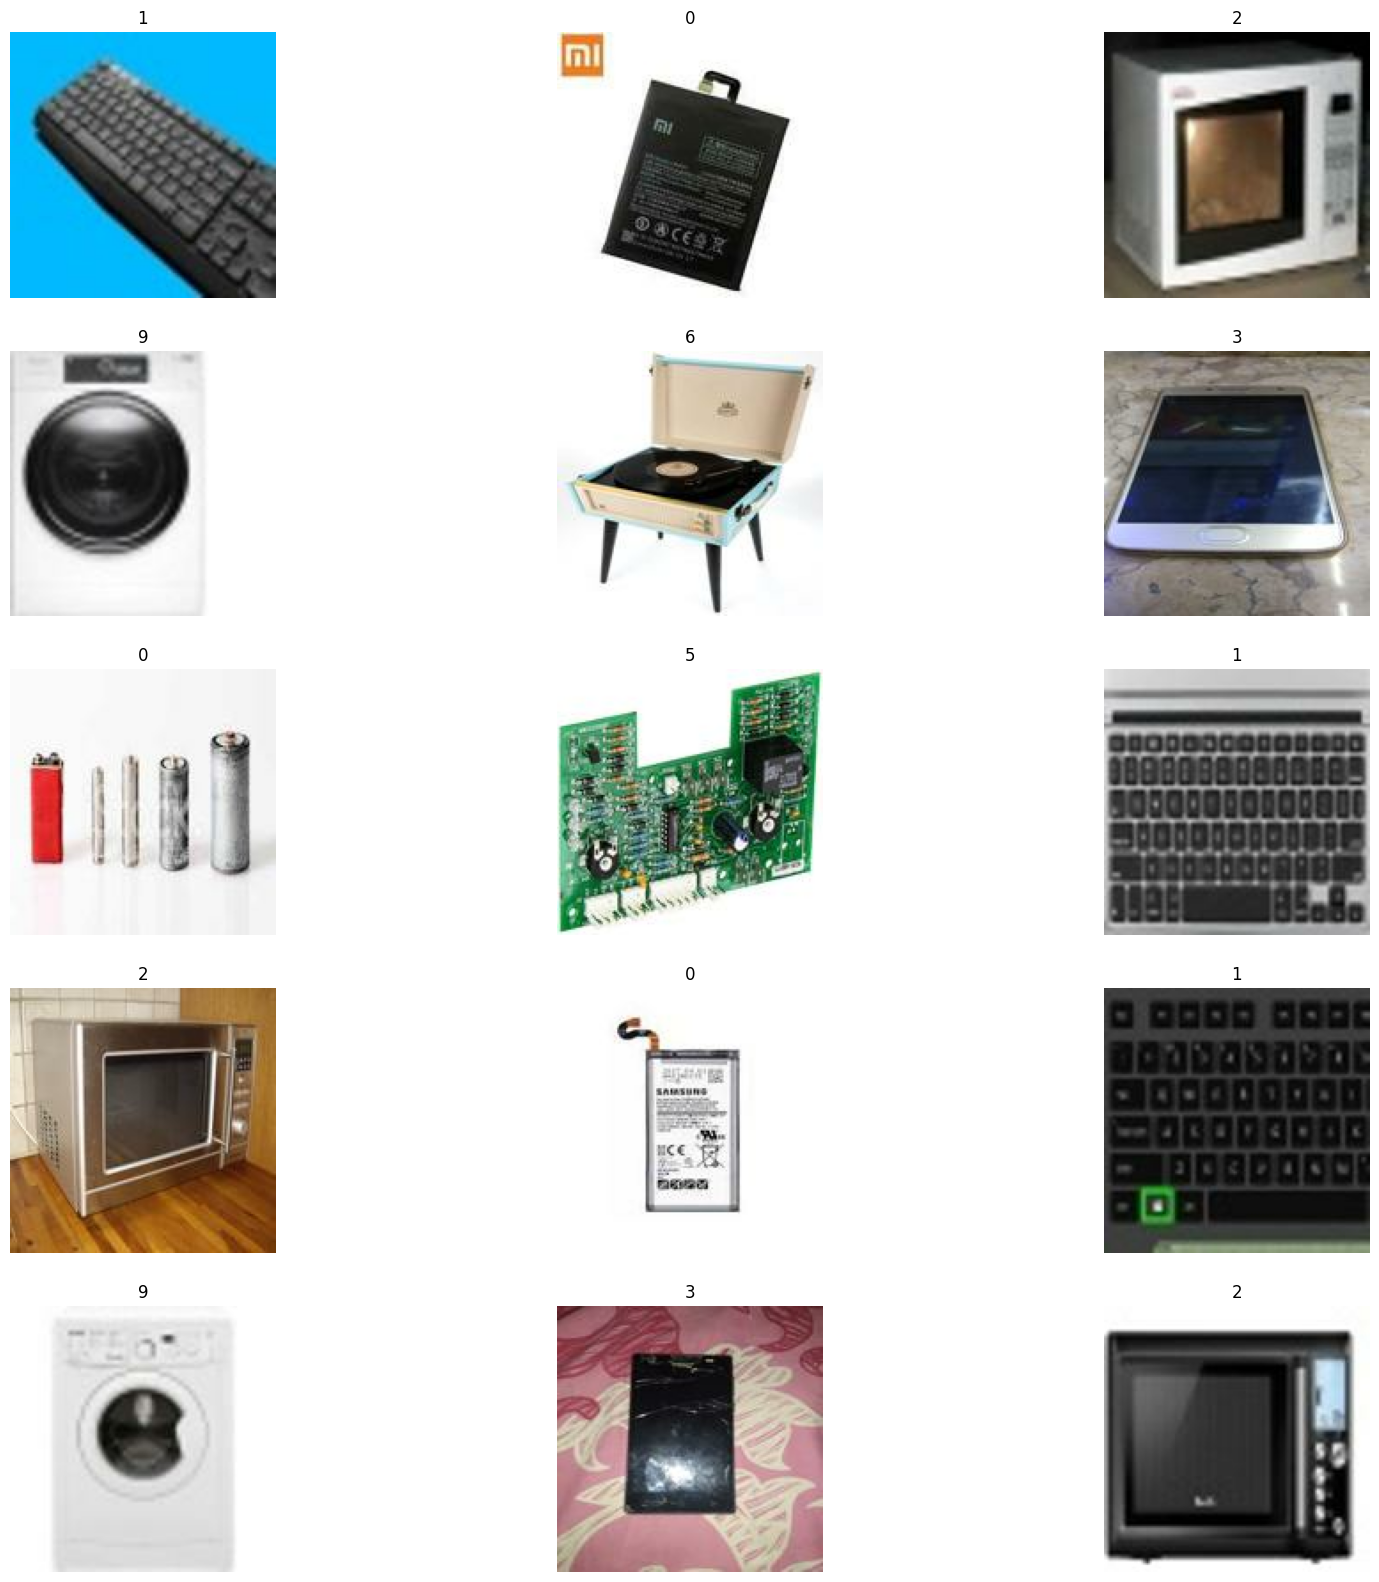

In [34]:
plt.figure(figsize=(20, 20))
for images, labels in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [35]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.35),
])

In [36]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(150, 150, 3), # Corrected input shape
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [37]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=5,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [38]:
# Combine data augmentation and base model to create the final model
model = Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax') # Assuming 10 classes based on the dataset output
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['Accuracy'])

In [39]:
epochs = 15

history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=epochs,
    batch_size=100,
    callbacks=[early]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - Accuracy: 0.6013 - loss: 1.2188 - val_Accuracy: 0.8400 - val_loss: 0.4902
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - Accuracy: 0.8550 - loss: 0.4203 - val_Accuracy: 0.8967 - val_loss: 0.2854
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - Accuracy: 0.8729 - loss: 0.3628 - val_Accuracy: 0.9000 - val_loss: 0.2529
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - Accuracy: 0.9185 - loss: 0.2601 - val_Accuracy: 0.9267 - val_loss: 0.2092
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - Accuracy: 0.9209 - loss: 0.2263 - val_Accuracy: 0.9367 - val_loss: 0.2429
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - Accuracy: 0.9396 - loss: 0.1672 - val_Accuracy: 0.9267 - val_loss: 0.2527
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - Accuracy: 0.9472 - loss: 0.1582 - val_Accuracy: 0.9167 - val_loss: 0.3371
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - Accuracy: 0.9549 - loss: 0.1346 - val_Accuracy: 0.9167 - v

In [48]:
model.save('Efficient_classify.keras')
print("model saved successfully")

model saved successfully


In [49]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [50]:
## base_model.summary() # Print the architecture summary of the base model

In [51]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

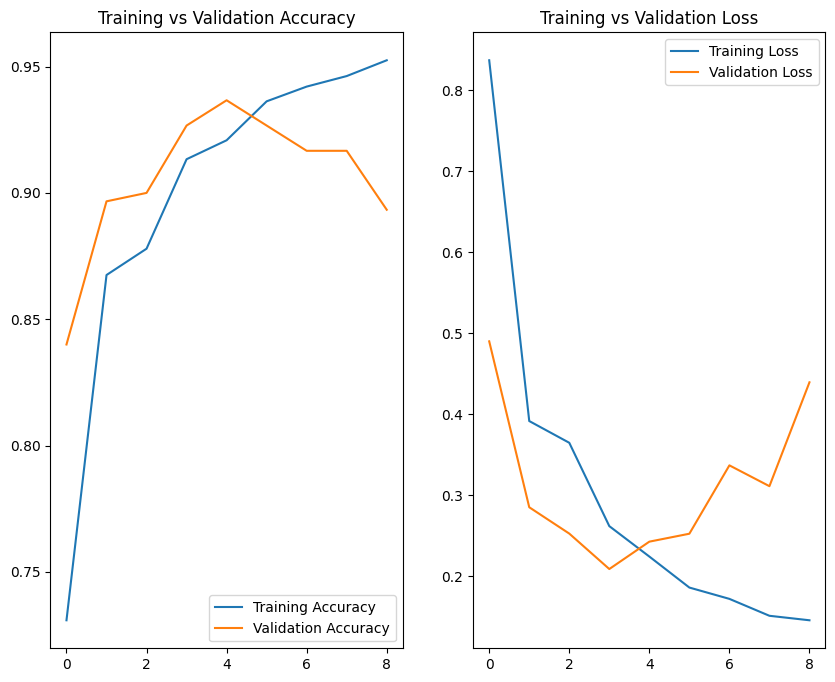

In [52]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [53]:
loss, accuracy = model.evaluate(data_test)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 858ms/step - Accuracy: 0.9120 - loss: 0.2713
Test accuracy is0.9067, Test loss is 0.2565


In [45]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in data_test], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(data_test)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
[[25  0  0  1  0  1  2  1  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 1  0 28  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  0  0  1  0  0]
 [ 0  0  0  0 28  0  1  1  0  0]
 [ 2  0  0  0  0 27  1  0  0  0]
 [ 1  0  0  1  0  0 26  2  0  0]
 [ 0  0  1  0  0  0  1 28  0  0]
 [ 0  0  3  0  0  0  2  1 24  0]
 [ 0  0  1  0  0  0  0  1  1 27]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       1.00      1.00      1.00        30
           2       0.85      0.93      0.89        30
           3       0.94      0.97      0.95        30
           4       1.00      0.93      0.97        30
           5       0.96      0.90      0.93        30
           6       0.79      0.87      0.83        30
           7       0.78      0.93      0.85        30
           8       0.96      0.80      0.87        30
           9       1.00      0.90      0.95        30

    accuracy                      

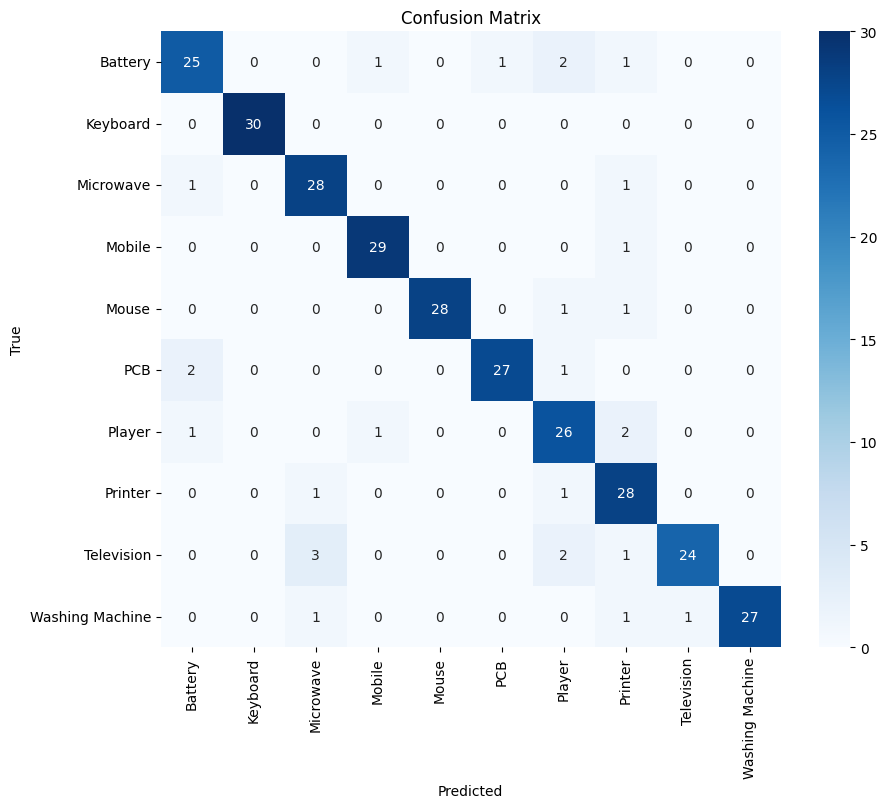

In [54]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=data_train.class_names,
            yticklabels=data_train.class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


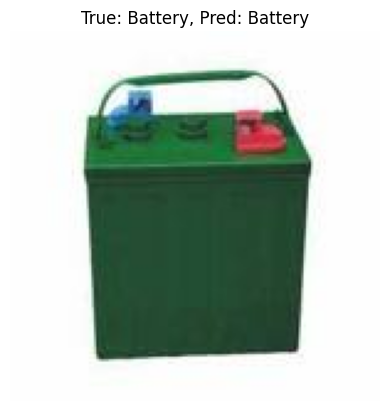

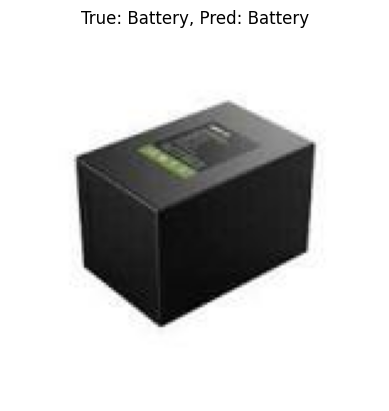

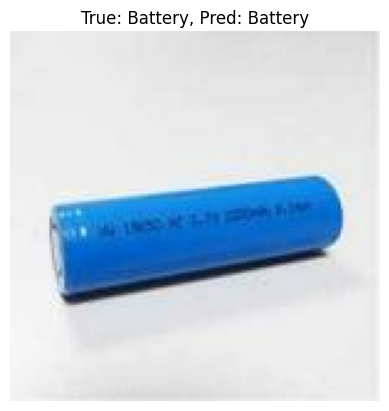

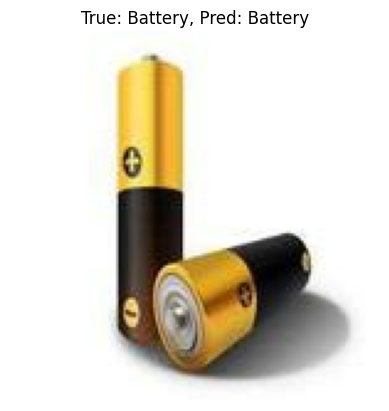

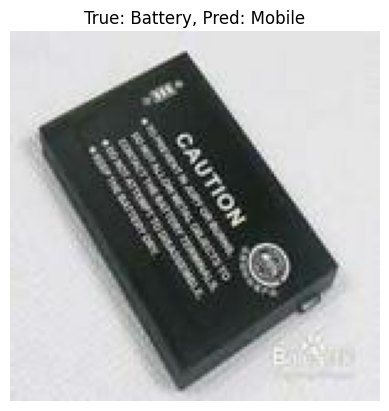

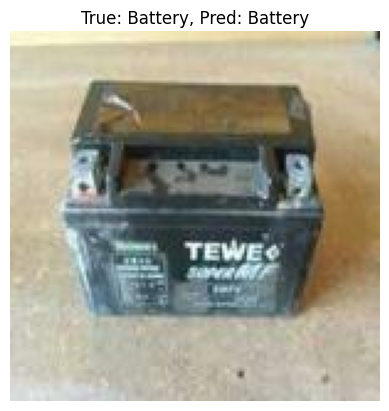

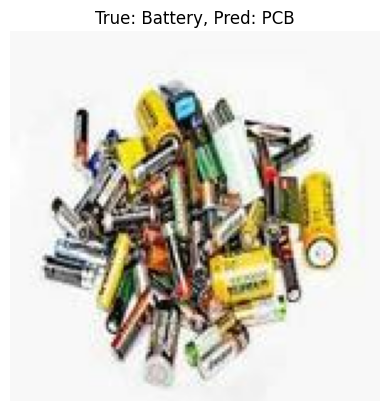

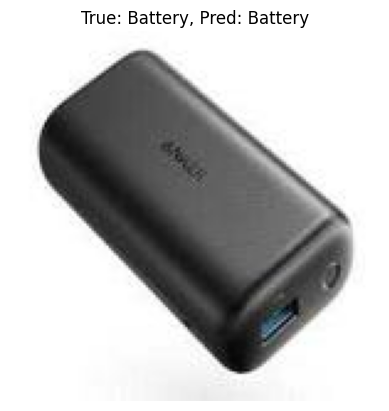

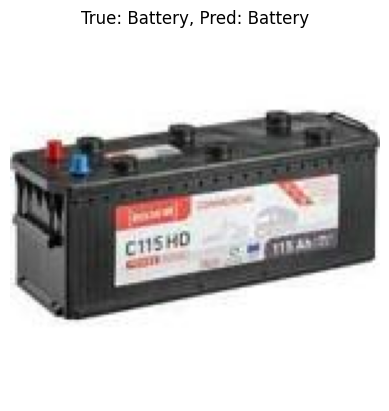

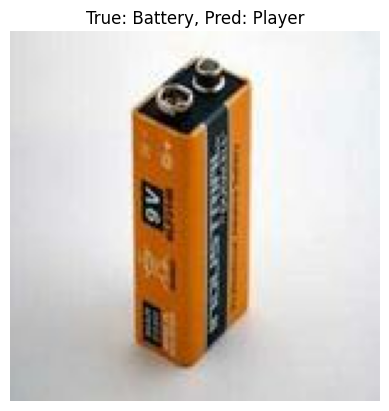

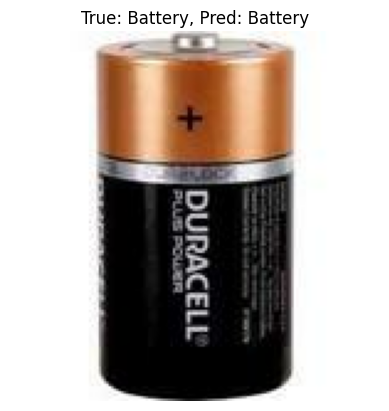

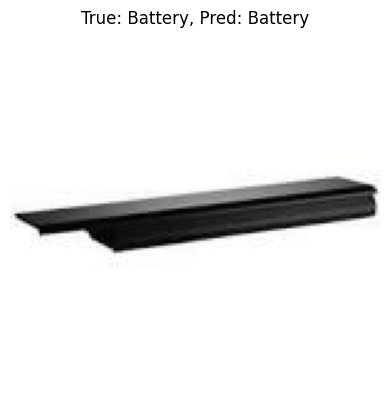

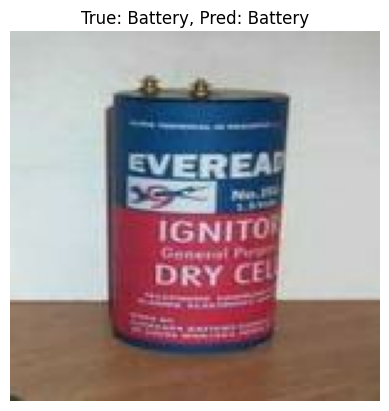

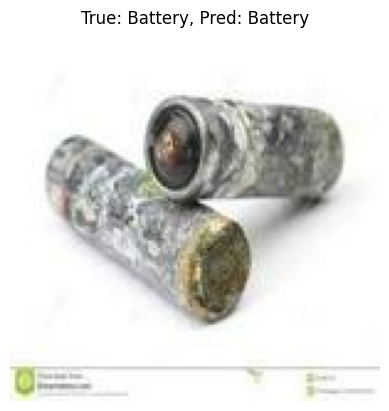

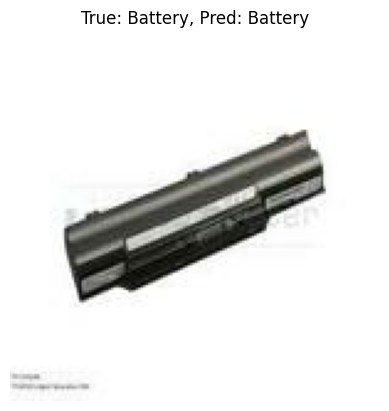

In [55]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = data_test.class_names                                           # Get class names from test dataset

for images, labels in data_test.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(15):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {data_train.class_names[labels[i]]}, Pred: {data_train.class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



In [56]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [57]:
def classify_image(img):
    # Step 1: Resize and convert to array

    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [99]:
user_info = {"name": ""}

# Classification function
def classify_image(img):
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]
    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

# Login simulation
def login(name, email, password):
    user_info["name"] = name
    return (
        gr.update(visible=False),  # name input
        gr.update(visible=False),  # email input
        gr.update(visible=False),  # password input
        gr.update(visible=False),  # login button
        gr.update(visible=False),  # login_heading ← Hides the login title
        gr.update(visible=True),   # show header (logo + title)
        gr.update(visible=True),   # image input
        gr.update(visible=True),   # prediction output
        gr.update(visible=True),   # classify button
        gr.update(visible=True)    # feedback section
    )

# Feedback logger + response
def collect_feedback(prediction, feedback_text):
    fb = feedback_text.lower()
    emoji = "😊" if any(w in fb for w in ["good", "great", "helpful", "useful"]) else (
            "😕" if any(w in fb for w in ["bad", "wrong", "confusing"]) else "👍")

    # Append to CSV
    entry = {"Name": user_info["name"], "Prediction": prediction, "Feedback": feedback_text}
    file_exists = os.path.exists("feedback_log.csv")
    pd.DataFrame([entry]).to_csv("feedback_log.csv", mode="a", header=not file_exists, index=False)

    msg = f"{emoji} Thank you, {user_info['name']}, for your feedback!"
    return msg, "feedback_log.csv"

# Gradio interface
with gr.Blocks(title="E-Waste Classifier Login") as demo:
    gr.HTML("""
        <style>
            body {
                background-color: #f9f9f9;
                padding: 0px 40px 40px 40px;
                font-family: 'Segoe UI', sans-serif;
            }

            /* Target only the action buttons inside image container */
                .logo-spin + div button,
                .logo-spin + div svg {
                display: none !important;
           }


            .logo-spin {
                animation: spin 8s infinite linear;
                display: block;
                margin: 0 auto 10px auto;
            }
            @keyframes spin {
                from { transform: rotateY(0deg); }
                to { transform: rotateY(360deg); }
            }
        </style>
    """)

    login_heading = gr.Markdown("<h2 ;>🔐 Sign In to Access the E-Waste Classifier</h2>", visible=True)

    gr.Markdown("""
    <h2 style='
        text-align:center;
        background:#eaffea;
        padding:10px 20px;
        border-radius:10px;
        margin-top:10px;
        font-weight:bold;
        color:#000000;
    '>
    ♻️ E-Waste Classifier 🔋🖥️
    </h2>
""")


    with gr.Column(elem_classes="gr-box"):
        name_input = gr.Textbox(label="Name")
        email_input = gr.Textbox(label="Email")
        password_input = gr.Textbox(label="Password", type="password")
        login_button = gr.Button("Login")

    # Animated logo + heading
    with gr.Column(visible=False) as header:
        gr.Image(value="E_Waste_logo.jpg", height=100, show_label=False, container=False, elem_classes="logo-spin")

        gr.Markdown("<h2 style='text-align:center;'>♻️📦 E-Waste Classification Dashboard 🔋🖥️</h2>")

    # Classifier interface
    image_input = gr.Image(type="pil", label="Upload E-Waste Image", visible=False)
    prediction_output = gr.Textbox(label="Prediction", visible=False)
    classify_button = gr.Button("🔍 Classify", visible=False)
    classify_button.click(fn=classify_image, inputs=image_input, outputs=prediction_output)

    # Feedback section
    with gr.Accordion("💬 Give Feedback (optional)", open=False, visible=False) as feedback_section:
        feedback_input = gr.Textbox(label="Your Feedback")
        feedback_submit = gr.Button("Submit")
        feedback_response = gr.Markdown()
        feedback_file = gr.File(label="⬇️ Download Your Feedback CSV", visible=False)
        feedback_submit.click(
            fn=collect_feedback,
            inputs=[prediction_output, feedback_input],
            outputs=[feedback_response, feedback_file]
        )

    # Login button action
    login_button.click(
        fn=login,
        inputs=[name_input, email_input, password_input],
        outputs=[
    name_input, email_input, password_input, login_button,
    login_heading, header, image_input, prediction_output, classify_button, feedback_section
]

    )

    from google.colab import files
files.upload()  # Then select logo.png


demo.launch(share=True)


Saving E_Waste_logo.jpg to E_Waste_logo (12).jpg
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://161bcd7f130f028c5e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
